# Creates K means clustering of autoencoder representations

## Imports and constants

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pickle
from get_orlov_datasets import get_orlov_datasets
from autoencoder import Autoencoder, Encoder, Decoder

KeyboardInterrupt: 

In [ ]:
SUBIMAGE_SIZE = 40
BATCH_SIZE = 256
TRAIN_SUBIMAGES_NUM = 16
NUM_LOADERS_WORKERS = 0
PRETRAINED_AUTOENCODER_FILE = './checkpoints/autoencoder/old/ldim-256_c_hid-32_lam-50-decoder_extended-3/checkpoints/epoch=14-step=570.ckpt'
# PRETRAINED_AUTOENCODER_FILE = 'C:/_DIPLOMA/code/checkpoints/autoenc4_test/lightning_logs/ldim-256_c_hid-32_lam-50-decoder_extended-3/checkpoints/epoch=14-step=570.ckpt'

## Load data and models

In [ ]:
train_loader, val_loader, test_loader, (data_train, data_test, _) = get_orlov_datasets(train_subimages_num=TRAIN_SUBIMAGES_NUM, 
                                                              num_loaders_workers=NUM_LOADERS_WORKERS,
                                                              batch_size=BATCH_SIZE)

In [ ]:
autoencoder_model = Autoencoder.load_from_checkpoint(PRETRAINED_AUTOENCODER_FILE)
encoder = Encoder(num_input_channels=3, base_channel_size=32, latent_dim=256)
encoder.load_state_dict(autoencoder_model.encoder.state_dict())

<All keys matched successfully>

## Use autoencoder to create subimages representations

In [ ]:
train_representations = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
encoder = encoder.to(device)

In [ ]:
for train_imgs, train_classes in tqdm(train_loader):
    with torch.no_grad():
        train_imgs = train_imgs.to(device)
        reps = encoder(train_imgs)
        train_representations.append(reps.cpu().detach().numpy())

100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


In [ ]:
train_reps_np = np.concatenate(train_representations, axis=0)
train_reps_np.shape

(4800, 256)

## Train K means algorithm and choose clusters count

In [ ]:
clusters_counts = [4, *[8 * i for i in range(1, 17)], 156, 190, 220, 256, 512]

In [ ]:
wcss = [] 
silhouettes = []
for number_of_clusters in tqdm(clusters_counts): 
    kmeans = KMeans(n_clusters = number_of_clusters, n_init=10)
    predicted = kmeans.fit_transform(train_reps_np)
    wcss.append(kmeans.inertia_)
    predicted_clusters = predicted.argmax(axis=1)
    silhouettes.append(silhouette_score(train_reps_np, predicted_clusters))

100%|██████████| 22/22 [02:51<00:00,  7.80s/it]


Compare methods based on plots. Clusters count from 30 to 50 seems resonable

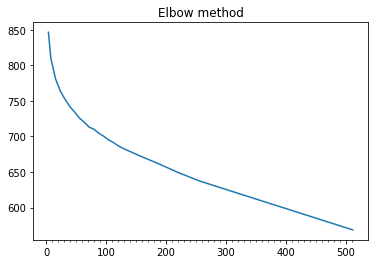

In [ ]:
plt.plot(clusters_counts, wcss)
plt.title("Elbow method")
plt.xticks([10*i for i in range(52)], minor=True)
plt.show()

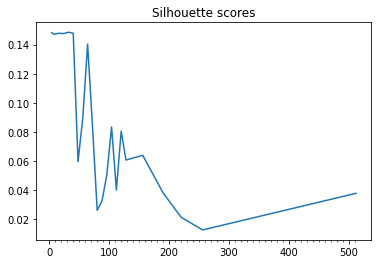

In [ ]:
plt.plot(clusters_counts, silhouettes)
plt.title("Silhouette scores")
plt.xticks([10*i for i in range(52)], minor=True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 48)
predicted = kmeans.fit_transform(train_reps_np)

In [ ]:
predicted_clusters = predicted.argmax(axis=1)
silhouette_score(train_reps_np, predicted_clusters)

0.14192708

In [ ]:
file_to_store = open('./checkpoints/kmeans/v1_KMeans.pkl', "wb")
pickle.dump(kmeans, file_to_store)
file_to_store.close()